In [1]:
#pip install ensae_teaching_cs
#pip uninstall numpy
#pip install river

import calendar
import datetime as dt
import math
from river import compose
from river import datasets
from river import linear_model
from river import metrics
from river import optim
from river import preprocessing
from river import time_series
from ensae_teaching_cs.data import google_trends
from river import stream
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Raw Package
import numpy as np
import pandas as pd
#Data Source
import yfinance as yf
import time
from ipywidgets import interactive


In [2]:
#create select list of coins
def f(crypto):
    return crypto

z = interactive(f, crypto=[('Bitcoin', 'BTC'), ('Ethereum', 'ETH'), ('Solana', 'SOL'), ('Cardano', 'ADA')]);
display(z)

interactive(children=(Dropdown(description='crypto', options=(('Bitcoin', 'BTC'), ('Ethereum', 'ETH'), ('Solan…

In [3]:
# function to convert a date to an integer
def get_ordinal_date(x):
    timestamp = x['date'].astype(np.int64)
    return {'ordinal_date': timestamp}

In [4]:
# date to integer transformer
extract_features = compose.TransformerUnion(
  get_ordinal_date
)

In [5]:
#create linear regression model
model = (
  extract_features |
  time_series.SNARIMAX(
    p=0,
    d=0,
    q=0,
    m=12,
    sp=3,
    sq=6,
    regressor=(
      preprocessing.StandardScaler() |
      linear_model.LinearRegression(
        intercept_init=110,
        optimizer=optim.SGD(0.01),
        intercept_lr=0.3
      )
    )
  )
)

In [6]:
#create metric for evaluation 
metric = metrics.Rolling(metrics.MAE(), 12)

In [7]:
# function to plot data
def plot_data(all_data, predicted_data):
    plt.figure(1, figsize=(20,7))
    plt.plot(all_data['date_'],all_data['Close'],label="dataset")
    plt.plot(predicted_data['date_'],predicted_data['Close'],label="predicted")
    plt.title("Close")
    plt.legend()
    plt.show()

In [8]:
# function to learn data
def learn_data(data,model,metric):
    X = data.copy()
    Y = X.pop('Close')
    for x, y in stream.iter_pandas(X,Y):
        i_date = {'date': x['date_']}
        y_pred = model.forecast(horizon=1, xs=[i_date])
        model = model.learn_one(i_date, y)
        metric = metric.update(y, y_pred[0])
    return i_date

In [9]:
# function to prediction
def prediction(horizon,i_date):
    predicted_data = []
    future = [
      {'date': i_date['date'] + np.timedelta64(1*m, 'm')}
      for m in range(1, horizon + 1)
    ]
    forecast = model.forecast(horizon=horizon, xs=future)
    for x, y_pred in zip(future, forecast):
        predicted_data.append([x['date'],y_pred])
    predicted_data = pd.DataFrame(predicted_data, columns=['date_', 'Close'])
    return predicted_data

[*********************100%***********************]  1 of 1 completed


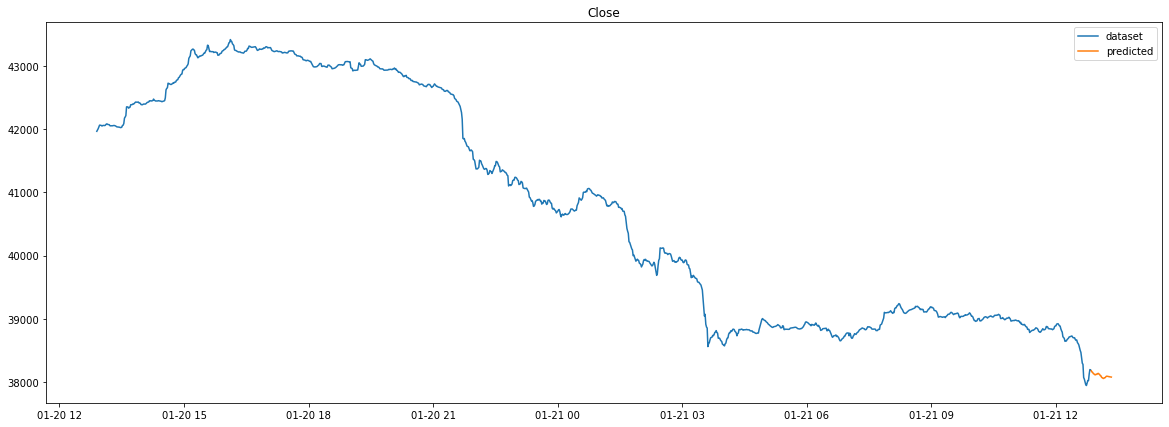

[*********************100%***********************]  1 of 1 completed


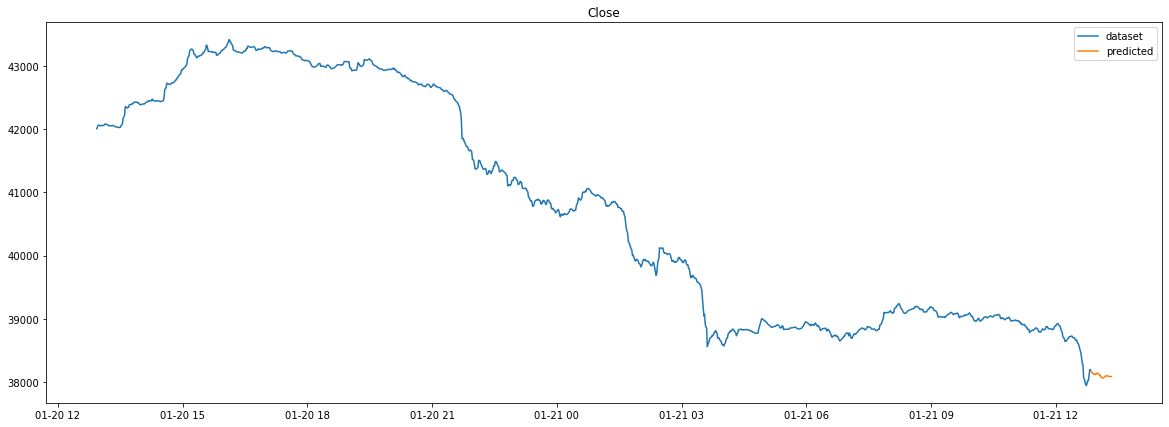

[*********************100%***********************]  1 of 1 completed


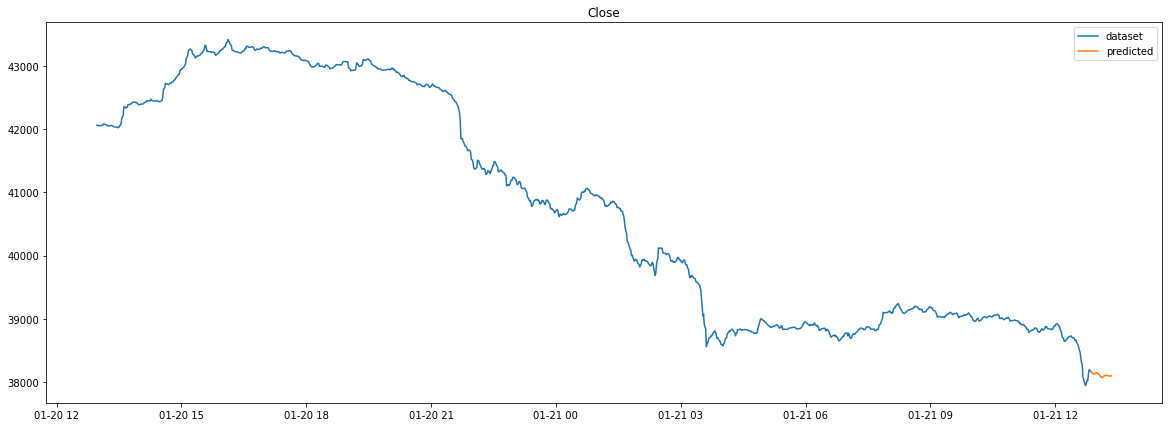

In [10]:
coin = z.result+'-USD'
data_learned = 0
for i in range(3):
    if i== 0:
        data = yf.download(tickers=coin, period = '24h', interval = '1m')
    else:
        data = yf.download(tickers=coin, period = '10h', interval = '1m')
    data.reset_index(inplace=True)
    data['Datetime'] = pd.to_datetime(data['Datetime'].dt.strftime("%Y-%m-%d %H:%M:%S"))
    data = data[['Datetime','Close']]
    data.columns = ['date_','Close']
    if i!= 0:
        data = data.loc[data['date_'] == data.iloc[-1]['date_'], :]
        all_data = all_data.append(data, ignore_index=True)
        all_data = all_data.iloc[1: , :]
    else:
        all_data = data
    data_learned = data_learned + data.shape[0]
    #print(data_learned)
    i_date = learn_data(data,model,metric)
    predicted_data = prediction(30,i_date)
    plot_data(all_data, predicted_data)
    time.sleep(60) # Delay for 1 minute (60 seconds).